In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import rasterio as rio
from rasterio.plot import reshape_as_image, reshape_as_raster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

In [2]:
def apply_mask(image):
    mask_norm = np.all((image >= 0) & (image <= 1), axis=2)
    mask_zero = np.all(image == 0, axis=2)
    image[(~mask_norm) | (mask_zero)] = np.nan
    image = reshape_as_raster(image)
    return image

In [3]:
image_path = r'C:\Users\arman\Desktop\INSA Toulouse\5A\PIR\Données\SENTINEL2B_20240410-112055-466_L2A_T29SQB_C_V3-1_FRE_extrait_stack_gain_VNIR10.img'
raster_img = rio.open(image_path)
arr_img = reshape_as_image(raster_img.read())
image = apply_mask(arr_img) # mask to delete bad pixels

l, m, n = image.shape # check the size of the image 
print("Size of the image is "+str(l)+"x"+str(m)+"x"+str(n))

X = image.reshape(l, -1).T

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Size of the image is 8x912x1178


In [27]:
def compute_ndvi(nir, red):
    nir = nir.astype(float)
    red = red.astype(float)
    
    ndvi = (nir - red) / (nir + red)
    
    # Évite les divisions par zéro
    ndvi = np.where((nir + red) == 0, 0, ndvi)
    
    return ndvi, nir

# Exemple d'utilisation :
ndvi, nir = compute_ndvi(image[-1,:,:], image[2,:,:])

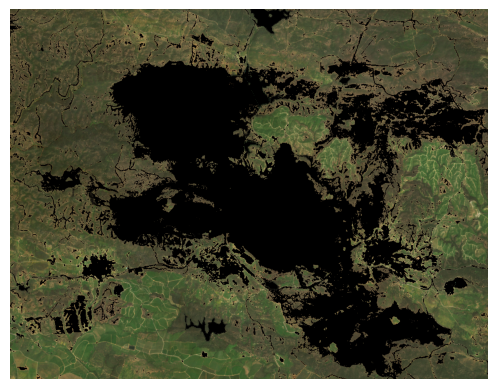

In [28]:
# Seuil NDVI (à ajuster selon ton cas)
threshold_ndvi = 0.4
threshold_nir = 2800

# Mask binaire : 1 = végétation, 0 = non-végétation
veg_mask = (ndvi > threshold_ndvi) #& (nir > threshold_nir)

# On étend le mask en 3D pour l’appliquer aux bandes
veg_mask_3d = veg_mask[None, :, :]  # shape -> (H, W, 1)

# Array final : mêmes dimensions, pixels non végétation = 0
veg_only = np.where(veg_mask_3d, image, 0)

# Indices Sentinel-2 : (si image = [B1, B2, B3, B4, B5, ...])
RED   = veg_only[2, :, :]
GREEN = veg_only[1, :, :]
BLUE  = veg_only[0, :, :]

rgb = np.stack([RED, GREEN, BLUE], axis=-1)

# Normalisation bande par bande
min_val = np.nanmin(rgb, axis=(0,1))
max_val = np.nanmax(rgb, axis=(0,1))

# Évite division par zéro
scale = max_val - min_val
scale[scale == 0] = 1  # remplacer 0 par 1 pour éviter le warning

rgb_norm = (rgb - min_val) / scale

plt.imshow(rgb_norm)
plt.axis('off')
plt.show()

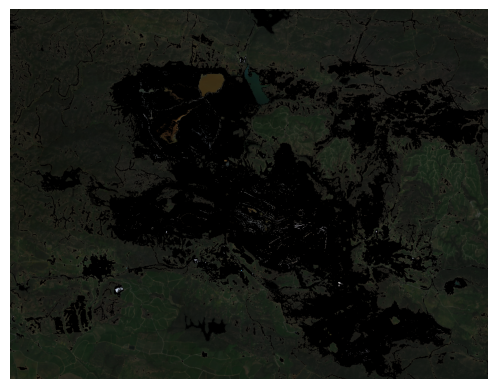

In [41]:
# Pixels restants (non-végétation)
non_veg_mask = ~veg_mask

# Extraire bandes nécessaires
green = image[1, :, :]  # B3
nir   = image[-1, :, :]  # B8

# Calcul NDWI
ndwi = (green - nir) / (green + nir)
ndwi = np.where((green + nir) == 0, 0, ndwi)

# Détection de l'eau
threshold_ndwi = 0  # à ajuster
water_mask = (ndwi > threshold_ndwi) & non_veg_mask

# Étendre le masque sur les bandes
water_mask_3d = water_mask[None, :, :]

# Pixels eau gardés, autres = 0
water_only = np.where(water_mask_3d, image, 0)

RED   = water_only[2, :, :] + veg_only[2, :, :]
GREEN = water_only[1, :, :] + veg_only[1, :, :]
BLUE  = water_only[0, :, :] + veg_only[0, :, :]

rgb_water = np.stack([RED, GREEN, BLUE], axis=-1)

# Normalisation bande par bande
min_val = np.nanmin(rgb_water, axis=(0,1))
max_val = np.nanmax(rgb_water, axis=(0,1))
scale = max_val - min_val
scale[scale == 0] = 1
rgb_norm = (rgb_water - min_val) / scale

plt.imshow(rgb_norm)
plt.axis('off')
plt.show()